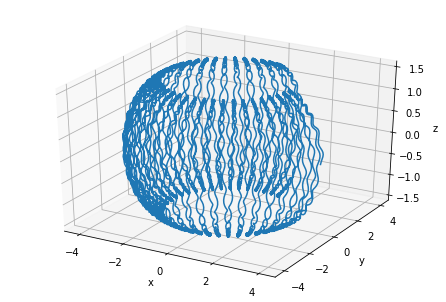

In [27]:
# tracer.py -- Calculate particle and guiding-center trajectories in magnetic fields
# M. Kaan Ozturk, Sep. 15, 2011

from scipy import *
from scipy.integrate import ode, odeint

from pylab import *
from mpl_toolkits.mplot3d import Axes3D

e = 1.602176565e-19 # Elementary charge (Coulomb)
m_pr = 1.672621777e-27 # Proton mass (kg)
m_el = 9.10938291e-31 # Electron mass (kg)
c = 299792458 # speed of light (m/s)
B0 = 3.07e-5 # Tesla
Re = 6378137 # meter (Earth radius)

def dipole(x,y,z):
    """Returns the dipole field of the Earth."""
    fac =  -B0*Re**3 / pow(x*x+y*y+z*z, 5.0/2.0)
    return [3*x*z*fac, 3*y*z*fac, (2*z*z -x*x- y*y)*fac]

def doubledipole(x,y,z):
	Bx1, By1, Bz1 = dipole(x,y,z)
	Bx2, By2, Bz2 = dipole(x-20*Re, y, z)
	return [Bx1+Bx2, By1+By2, Bz1+Bz2]

def SolveNewtonLorenz(x0, y0, z0, vx0, vy0, vz0, tend,
                      field=dipole, m=m_pr, q=e):
	"""Returns the trajectory of a particle.
	x0, y0, z0 : Initial position
	vx0, vy0, vz0: Initial velocity
	tend: Stopping time
	field: Function returning the magnetic field (def. dipole)
	m : mass of particle (def. proton)
	q : charge of particle (def. proton)"""
	vsq = vx0**2 + vy0**2 + vz0**2
	gamma = 1.0/sqrt(1 - vsq/c**2)
	Bx, By, Bz = field(x0, y0,z0)
	B = sqrt(Bx*Bx + By*By + Bz*Bz)
	T = 2*pi*gamma*m/(abs(q)*B) # cyclotron period
	dt = T/10       # time step automatically set
	
	def deriv(Y, t=0):
		x,y,z,vx,vy,vz = Y
		Bx, By, Bz = field(x,y,z)
		fac = q/(m*gamma)
		return [ vx, vy, vz,
				 fac*(vy*Bz - vz*By),
				 fac*(vz*Bx - vx*Bz),
				 fac*(vx*By - vy*Bx) ]
	
	t = arange(0, tend, dt)
	y = odeint(deriv, [x0, y0, z0, vx0, vy0, vz0], t)
	return y

def SolveGC(x0, y0, z0, vp0, v, dt, tend,
            field=dipole, m=m_pr, q=e):
	"""Returns the guiding-center trajectory.
	x0, y0, z0 : Initial position
	vp0: Initial parallel speed
	v : Speed
	dt: time step
	tend: Stopping time
	field: Function returning the magnetic field (def. dipole)
	m : mass of particle (def. proton)
	q : charge of particle (def. proton)"""
	vsq = v*v
	gamma = 1.0/sqrt(1 - vsq/c**2)
	Bx, By, Bz = field(x0, y0, z0)
	B0 = sqrt(Bx*Bx + By*By + Bz*Bz)
	mu = gamma**2*m*(vsq-vp0**2)/(2*B0) # magnetic moment
	
	def B(x,y,z):
		Bx, By, Bz = field(x, y, z)
		return sqrt(Bx*Bx + By*By + Bz*Bz)    
	def unitb(x,y,z):
		"""Returns the field strength and direction at point (x,y,z)."""
		Bx, By, Bz = field(x, y, z)
		B = sqrt(Bx*Bx + By*By + Bz*Bz)
		return B, [Bx/B, By/B, Bz/B]
	def gradB(x,y,z, d=0.001*Re):
		"""Returns the gradient of field strength at point (x,y,z)."""
		return [(B(x+d,y,z) - B(x-d,y,z))/(2*d),
				(B(x,y+d,z) - B(x,y-d,z))/(2*d),
				(B(x,y,z+d) - B(x,y,z-d))/(2*d)]
	def dotpr(a,b):
		"""Returns the dot product of lists a and b."""
		if len(a)==len(b):
			return sum([a[i]*b[i] for i in range(len(a))])
	def crosspr(a,b):
		"""Returns the cross product of lists a and b."""
		if len(a)==len(b)==3:
			return [a[1]*b[2]-a[2]*b[1],
					a[2]*b[0]-a[0]*b[2],
					a[0]*b[1]-a[1]*b[0]]
	def deriv(Y, t=0):
		x,y,z,vp = Y
		B, bdir = unitb(x,y,z)
		gB = gradB(x,y,z)
		fac = gamma*m/(2*q*B**2) * (vsq + vp**2)
		bxgB = crosspr(bdir, gB)
		return [ fac*bxgB[0] + vp*bdir[0],
				 fac*bxgB[1] + vp*bdir[1],
				 fac*bxgB[2] + vp*bdir[2],
				 -mu/(m*gamma**2) * dotpr(bdir, gB) ]
	
	t = arange(0, tend, dt)
	y = odeint(deriv, [x0, y0, z0, vp0], t)
	return y

def SecInv(t,y,v):
    """Evaluates the second invariant I as int vp^2 dt / v.
    Uses the output of SolveGC."""
    # Subdivide the vp(t) into half-cycles.
    # Evaluate each integral over a half-cycle.
    vp = y[:,3]
    # Find indices of points just before vp changes sign:
    precrossindices= [i for i in range(len(vp)-1) if vp[i]*vp[i+1] < 0]
    # Using interpolation, find approximate the times where vp==0
    crosstimes = [ (vp[i+1]*t[i] - vp[i]*t[i+1])/(vp[i+1]-vp[i]) for i in precrossindices]
    # Set up the integrand data points:
    datap = zip(t, [u**2 for u in vp])
    secinv = []
    # Iterate over half-cycles and evaluate the invariant integral
    for i in range(len(crosstimes)-1):
        lowlim, upperlim = crosstimes[i], crosstimes[i+1]
        # Append and prepend zero values to the integrand:
        integrand = array( [(lowlim,0)]+
                     [p for p in datap if p[0]>=lowlim and p[0]<=upperlim]+
                     [(upperlim, 0)] )
        # Evaluate the integral with trapezoidal method:
        secinv.append( trapz(integrand[:,1], integrand[:,0])/v )
    return crosstimes, secinv

def Display3D(y):
    """Displays the trajectory of the particle.
    Input parameter y should be the output of SolveNewtonLorentz or SolveGC."""

    fig = figure()
    ax = Axes3D(fig)
    #ax.set_aspect('equal')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.plot(y[:,0]/Re, y[:,1]/Re, y[:, 2]/Re)

def Save(y, filename):
    """Save the output y in file 'filename' as text. Overwrites existing data."""
    f=open(filename, "w")
    for vec in y:
        line=""
        for n in vec:
            line += str(n)+' '
        f.write(line+'\n')
    f.close()

# ---- Example programs using the functions above -----
def main1():
	# Trajectory of a proton with 10 MeV kinetic energy in dipole field
	K = 1e7 # kinetic energy in eV
	K = K*e   # convert to Joule
	# Find corresponding speed:
	v = c/sqrt(1+(m_pr*c**2)/K) # replace m_pr with m_el for electron
	
	x0 = 4*Re; y0 = 0; z0 = 0;
	pitch_angle = 30.0 # initial angle between velocity and mag.field (degrees)
	if pitch_angle==90:
		vz0 = 0  # avoids some numerical instabilities
	else:
		vz0 = v*cos(pitch_angle*pi/180)
	vy0 = v*sin(pitch_angle*pi/180)
	vx0 = 0
	tend = 120 # end time
	y = SolveNewtonLorenz(x0, y0, z0, vx0, vy0, vz0, tend)
	Display3D(y)
	# Save(y, "proton.dat") # Uncomment to save in a text file for further processing
	show()
	
def main2():
	# Guiding-center trajectory of a proton with 10MeV kinetic energy in dipole field
	K = 1e7 # kinetic energy in eV
	K = K*e   # convert to Joule
	# Find corresponding speed:
	v = c/sqrt(1+(m_pr*c**2)/K) # replace m_pr with m_el for electron
	
	x0 = 4*Re; y0 = 0; z0 = 0;
	pitch_angle = 30.0 # initial angle between velocity and mag.field (degrees)
	if pitch_angle==90:
		vp0 = 0  # avoids some numerical instabilities
	else:
		vp0 = v*cos(pitch_angle*pi/180)
	tend = 120
	dt = 0.01;
	y = SolveGC(x0, y0, z0, vp0, v, dt, tend)
	Display3D(y)
	
	# Evaluate the second invariant along the guiding-center trajectory
	t, eye = SecInv(arange(0,tend,dt), y, v)
	figure(); plot(t[:-1],[i/Re for i in eye], '.-')
	show()
	
def main3():
	# Trajectory of an electron with 100keV kinetic energy in double dipole field
	K = 1e6 # kinetic energy in eV
	K = K*e   # convert to Joule
	# Find corresponding speed:
	v = c/sqrt(1+(m_el*c**2)/K)
	x0 = -10*Re; y0 = 0; z0 = 0;
	
	pitch_angle = 70.0 # initial angle between velocity and mag.field (degrees)
	if pitch_angle==90:
		vz0 = 0  # avoids some numerical instabilities
	else:
		vz0 = v*cos(pitch_angle*pi/180)
	vy0 = v*sin(pitch_angle*pi/180)
	vx0 = 0
	tend = 10 # end time

	dt = 0.01;
	y = SolveNewtonLorenz(x0, y0, z0, vx0, vy0, vz0,tend, field=doubledipole, m=m_el, q=-e)
	Display3D(y)
	show()

def main4():
	# Trajectory of a proton with 1 MeV kinetic energy in double-dipole field
	# drift-shell bifurcation observed
	K = 2e5 # kinetic energy in eV
	K = K*e   # convert to Joule
	# Find corresponding speed:
	v = c/sqrt(1+(m_pr*c**2)/K) # replace m_pr with m_el for electron
	
	x0 = 7*Re; y0 = 7.0*Re; z0 = 0;
	pitch_angle = 60.0 # initial angle between velocity and mag.field (degrees)
	if pitch_angle==90:
		vz0 = 0  # avoids some numerical instabilities
	else:
		vz0 = v*cos(pitch_angle*pi/180)
	vy0 = v*sin(pitch_angle*pi/180)
	vx0 = 0
	tend = 1000 # end time
	y = SolveNewtonLorenz(x0, y0, z0, vx0, vy0, vz0, tend, field=doubledipole)
	Display3D(y)
	#Save(y, "protonDSB.dat") # Uncomment to save in a text file for further processing
	show()
	
if __name__ == "__main__":
	main1()